# Face Landmarks Modeling Preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.insert(0, '../')
from shared import hist3d_data, capture_df, frame
from landmarks import landmarks, plot_landmarks, show_eyes
import facial_model as fm

/home/rcdilorenzo/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The first step is to combine all of the pre-computed face landmarks across the 25 batches (~ 5 days of on-and-off computational work). Then, the `numpy` arrays can be easily combined into the original data frame to make have all of the relevant data in a single place. See [landmarks.py](../landmarks.py) for implementation details.

In [2]:
has_landmarks = lambda x: x.shape[0] > 0

df = capture_df()
df['Landmarks'] = landmarks()
df = df[df.Landmarks.apply(has_landmarks)]

print('data frame (with landmarks)', df.shape)

data frame (with landmarks) (1900736, 34)


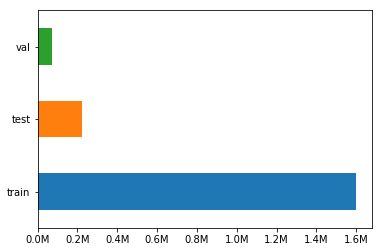

In [3]:
ax = df.Dataset.value_counts().plot(kind='barh')
vals = ax.get_xticks()
ax.set_xticklabels(['{:,.1f}M'.format(x / 1000000) for x in vals])
plt.show()

In [4]:
df.head()

,appleRightEye.H,appleRightEye.W,appleRightEye.X,appleRightEye.Y,appleRightEye.IsValid,Frame,appleLeftEye.H,appleLeftEye.W,appleLeftEye.X,appleLeftEye.Y,...,faceGrid.IsValid,dotInfo.DotNum,dotInfo.XPts,dotInfo.YPts,dotInfo.XCam,dotInfo.YCam,dotInfo.Time,Dataset,DeviceName,Landmarks
0,64.8,64.8,46.68,54.959999,1,02413/frames/00000.jpg,64.8,64.8,124.44,54.959999,...,1,0,76.812234,849.008106,-4.856807,-14.235245,0.527305,test,iPad Mini,"[[173.0, 412.0, -72.0109], [176.0, 441.0, -71...."
1,64.8,64.8,46.68,80.879999,1,02413/frames/00001.jpg,64.8,64.8,127.68,77.639999,...,1,0,76.812234,849.008106,-4.856807,-14.235245,0.635693,test,iPad Mini,"[[202.0, 452.0, -74.60888], [202.0, 479.0, -75..."
2,64.8,64.8,27.24,80.879999,1,02413/frames/00002.jpg,64.8,64.8,108.24,77.639999,...,1,0,76.812234,849.008106,-4.856807,-14.235245,0.740959,test,iPad Mini,"[[176.0, 465.0, -68.58406], [180.0, 490.0, -70..."
3,64.8,64.8,11.04,64.679999,1,02413/frames/00003.jpg,64.8,64.8,95.28,58.199999,...,1,0,76.812234,849.008106,-4.856807,-14.235245,0.846996,test,iPad Mini,"[[180.0, 472.0, -71.60969], [183.0, 501.0, -72..."
4,64.8,64.8,20.76,41.999999,1,02413/frames/00004.jpg,64.8,64.8,101.76,38.759999,...,1,0,76.812234,849.008106,-4.856807,-14.235245,0.960169,test,iPad Mini,"[[169.0, 469.0, -63.52331], [173.0, 497.0, -65..."


From here, the landmarks from an arbitrary batch can be verified--that they properly correspond to each image at the same index. Note that images that do not have any landmarks detected are denoted by an empty `numpy` array.

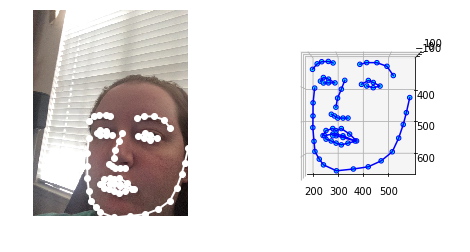

In [5]:
plot_landmarks(df.iloc[411100])

## Distribution of X, Y, Z

From here, the distribution of the values must be known in order to prepare a proper scaling method since neural networks work better on smaller values due to backpropogation derivatives and the node weights.

In [6]:
x = np.vstack(df.Landmarks)[:, 0]
y = np.vstack(df.Landmarks)[:, 1]
z = np.vstack(df.Landmarks)[:, 2]

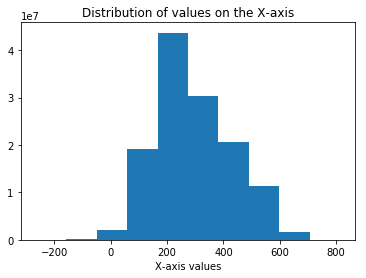

min -266.0
max 814.0
mean 294.03125
median 272.0


In [7]:
plt.hist(x)
plt.title('Distribution of values on the X-axis')
plt.xlabel('X-axis values')
plt.show()

print('min', np.min(x))
print('max', np.max(x))
print('mean', np.mean(x))
print('median', np.median(x))

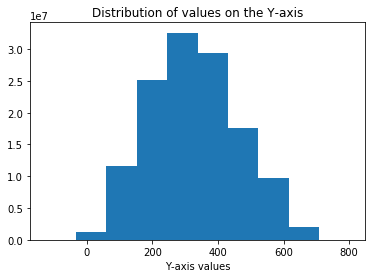

min -126.0
max 802.0
mean 326.52066
median 321.0


In [8]:
plt.hist(y)
plt.title('Distribution of values on the Y-axis')
plt.xlabel('Y-axis values')
plt.show()

print('min', np.min(y))
print('max', np.max(y))
print('mean', np.mean(y))
print('median', np.median(y))

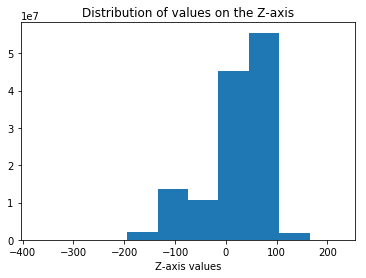

min -374.14056
max 225.13248
mean 21.106413
median 39.93457


In [9]:
plt.hist(z)
plt.title('Distribution of values on the Z-axis')
plt.xlabel('Z-axis values')
plt.show()

print('min', np.min(z))
print('max', np.max(z))
print('mean', np.mean(z))
print('median', np.median(z))

min -266.0
max 814.0


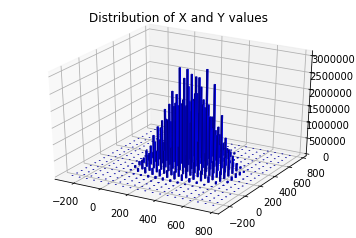

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
(xpos, ypos, zpos), (dx, dy, dz) = hist3d_data(x, y)
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
plt.title('Distribution of X and Y values')
plt.show()

## Transformations

For an input into the network, not only are the facial landmarks required, but it'll also need an image of each of the eyes as an image input. Therefore, a function is needed to produce the two eye images from a single row (that includes the discovered landmarks. See `fm.eyes_tensor()` from [facial_model.py](./facial_model.py) for details.

### Extracting Eye Partials

In [11]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
import keras.backend as K

K.clear_session()

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
K.set_session(sess)

Using TensorFlow backend.


box (313, 398, 348, 433)
box (187, 257, 344, 412)


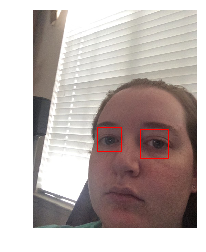

Left eye


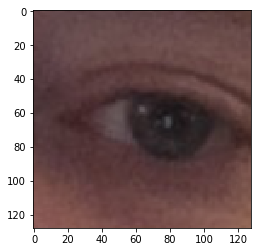

Right eye


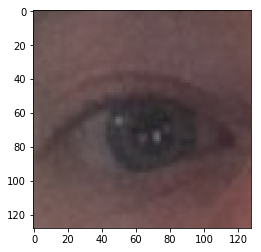

In [12]:
import matplotlib as mpl

sample_row = df.iloc[411100]

(predictions, image, factor,
 left_eye_op, right_eye_op,
 left_box, right_box) = fm.eyes_tensor()

data_input = {
    image: frame(sample_row),
    predictions: sample_row.at['Landmarks'][:, 0:2].astype(np.int32),
    factor: 1.5
}

(left_eye, right_eye, left_box, right_box) = sess.run(
    (left_eye_op, right_eye_op, left_box, right_box),
    feed_dict=data_input)

fig, ax = plt.subplots()
show_eyes(df.iloc[411100], left_box, right_box, axis=ax)

print('Left eye')
plt.imshow((left_eye * 255).astype(np.uint8))
plt.show()

print('Right eye')
plt.imshow((right_eye * 255).astype(np.uint8))
plt.show()

### Scaling Face Landmarks

The next transformation necessary is scaling the facial landmark points. As seen below, because there are +120M faces that were non-empty, the domain of our scaling function should be able to just use the minimum and maximum in all three axes.

In [13]:
print('Non-empty facial feature rows:', x.shape[0])

Non-empty facial feature rows: 129250048


In [14]:
from sklearn.preprocessing import StandardScaler

# Flatten all landmarks to series of points and then use to create scaler
scaler = StandardScaler(copy=True).fit(np.vstack(df.Landmarks)[:, :])

In [15]:
# Compare original to scaled points
print('original:\n', df.Landmarks.iloc[0][0:5])

# Sample of transformed points
print('scaled:\n', scaler.transform(df.Landmarks.iloc[0][0:5]))

original:
 [[173.       412.       -72.0109  ]
 [176.       441.       -71.95459 ]
 [184.       469.       -71.77404 ]
 [191.       491.       -68.63147 ]
 [198.       516.       -56.336536]]
scaled:
 [[ 0.26462147  1.5045862  -1.7504267 ]
 [ 0.2811313   1.6609318  -1.7492954 ]
 [ 0.3251575   1.8118863  -1.745668  ]
 [ 0.36368042  1.9304934  -1.6825322 ]
 [ 0.40220335  2.065274   -1.435521  ]]


At this point, all of the inputs have been preprocessed enough for the neural network to be formed. See [model.ipynb](./model.ipynb) for the next stage.